## Imports and settings

In [1]:
import src
import keras.backend as K
from os import *
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/trainings')
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#forces CPU usage
environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15994628359161477636
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16320522260542406490
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [3]:
past = 1

In [4]:
train, xval, test = src.load_datasets(past_frames=past)

Training data: (7500, 64, 64, 2)
Validation data: (1500, 64, 64, 2)
Test data: (1000, 64, 64, 2)


In [5]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train[:2000], xval, test, past_frames=past, augment=True)

Data augmentation.
Shape of training data:  (8000, 64, 64, 1) 
Shape of training truth:  (8000, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 1) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 1) 
Shape of test truth:  (1000, 64, 64, 1)


## U-net

In [6]:
#IMPORTANT!!!
name = f"unet_{past}"

In [7]:
model = src.unet(input_shape=(64, 64, past), dropout=0, batchnorm=True)

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   272         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
#train the model
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss=src.custom_loss("l1"), metrics=[src.relative_error_tensor]) 

***Using L1 loss.***
Tensor("metrics/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("conv2d_transpose_5_target:0", shape=(?, ?, ?, ?), dtype=float32)


In [10]:
model.fit(gan_train,
          gan_truth,
          batch_size = 64,
          epochs=20,
          validation_data=(gan_val,gan_val_truth),
          shuffle = True)

Train on 8000 samples, validate on 1500 samples
Epoch 1/20
8000/8000 [==============================] - 13s 2ms/step - loss: 0.2133 - relative_error_tensor: 1.1809 - val_loss: 0.1770 - val_relative_error_tensor: 0.9938
Epoch 2/20
8000/8000 [==============================] - 14s 2ms/step - loss: 0.1349 - relative_error_tensor: 0.7480 - val_loss: 0.1526 - val_relative_error_tensor: 0.8574
Epoch 3/20
8000/8000 [==============================] - 19s 2ms/step - loss: 0.1212 - relative_error_tensor: 0.6721 - val_loss: 0.1269 - val_relative_error_tensor: 0.7131
Epoch 4/20
8000/8000 [==============================] - 17s 2ms/step - loss: 0.1150 - relative_error_tensor: 0.6378 - val_loss: 0.1140 - val_relative_error_tensor: 0.6403
Epoch 5/20
8000/8000 [==============================] - 19s 2ms/step - loss: 0.1114 - relative_error_tensor: 0.6178 - val_loss: 0.1090 - val_relative_error_tensor: 0.6126
Epoch 6/20
8000/8000 [==============================] - 23s 3ms/step - loss: 0.1091 - relative_er

## Save features

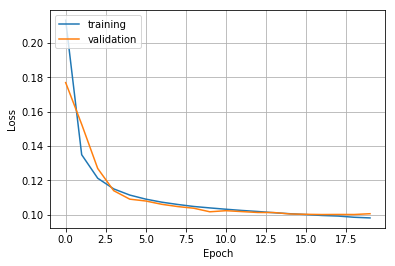

In [11]:
hist = model.history
hist.history.keys()
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig(name+'_curves.png')

Save model history

In [12]:
np.save(name+"_log",hist.history)

Save model weights

In [13]:
model.save_weights(name+"_model.h5")

Load model and predict

In [ ]:
model.load_weights(sys.path[1]+f"/U-net_{past}-1/"+name+"_model.h5")

Predict future frames

In [14]:
train, xval, test = src.load_datasets(past_frames=8)

Training data: (7500, 64, 64, 8)
Validation data: (1500, 64, 64, 8)
Test data: (1000, 64, 64, 8)


In [15]:
test_data = src.augment_data(test[:100])

In [16]:
#test
predictions = {}
past_frames = test_data[...,0:past]
test_truth = test_data[...,past:past+1]
for t in range(4): #predict 4 next
    predictions[f"{t}"] = model.predict(past_frames, batch_size=64)
    past_frames = np.concatenate((past_frames[:,:,:,1:], predictions[f"{t}"]), axis=-1)
    test_truth = test_data[...,past+1+t:past+2+t]

Save example predictions

In [19]:
save_examples(name, test_data, predictions, past, samples=[33,46,54])

In [18]:
def save_examples(name, test, predictions_dict, past_frames, samples=0):
    fig, axs = plt.subplots(len(samples)*2,past+4, figsize=(32, 32))
    fig.subplots_adjust(wspace=0.3, hspace=0.0)
    for n in range(len(samples)):
        vmax = np.max(test[n,:,:,:past])
        vmin = 0
        for i in range(past):
            im = axs[2*n,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
        for i in range(past,past+4):
            im = axs[2*n,i].imshow(predictions_dict[f"{i-past}"][samples[n], :,:,0], vmax=vmax, vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Predicted frame {i-past+1}")
            src.colorbar(im)                
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax, vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Reference frame {i-past+1}")
            src.colorbar(im)
    fig.savefig(f"Plots/{name}_sequence_prediction.png")
    plt.close()

Calculate scores

In [20]:
list(predictions.keys())

['0', '1', '2', '3']

In [21]:
norms = np.load(sys.path[0]+"/5min_norms_compressed.npz")["arr_1"]

In [22]:
# *4 bc of augmentaion (it concats the frames so the 0th 1000th 2000th and 3000th are the same sample just rotated)
test_norms = list(norms[9000:])*4

In [23]:
#renormalize test samples
renormalized_test = np.array([sample * np.array(test_norms)[i] for i, sample in enumerate(test_data)])
renormalized_predictions = np.transpose((np.array([[sample * np.array(test_norms)[i] for i, sample in enumerate(predictions[key])] for key in list(predictions.keys())])[:,:,:,:,0]), (1,2,3,0))

In [24]:
renormalized_predictions.shape

(400, 64, 64, 4)

In [25]:
#thresholds: 2, 8, 42
thresholds = [10, 50, 100]
scores = {}
for t in range(renormalized_predictions.shape[-1]): # loop over the predictions (4)
    for s in thresholds: # make a dict entry for each threshold score
        scores[f"pred_{t+1}_threshold_{s}"] = src.calculate_skill_scores(renormalized_predictions[...,t:t+1],
                                                                                     renormalized_test[...,past+t:past+1+t],
                                                                                     x=renormalized_test[...,:past],
                                                                                     threshold=s)

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:845: RuntimeWarning: invalid value encountered in true_divide
  scores["far"] = false_alarms/(hits+false_alarms)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:843: RuntimeWarning: invalid value encountered in true_divide
  scores["csi"] = hits/(hits+misses+false_alarms)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:847: RuntimeWarning: invalid value encountered in true_divide
  scores["pod"] = hits/(hits+misses)


In [26]:
scores["pred_1_threshold_10"].keys()

dict_keys(['csi', 'far', 'pod', 'corr_to_truth', 'corr_to_input'])

In [27]:
np.save(name+"_scores",scores)

In [28]:
name

'unet_1'

In [ ]:
loaded_scores = np.load(sys.path[1]+f"/U-net_{past}-1/"+name+"_scores.npy").item()

In [ ]:
list(loaded_scores.keys())

In [ ]:
np.mean((pd.Series(loaded_scores["pred_1_threshold_100"]["corr_to_truth"]).dropna()))

In [ ]:
np.mean((pd.Series(loaded_scores["pred_2_threshold_100"]["corr_to_truth"]).dropna()))

In [ ]:
np.mean((pd.Series(loaded_scores["pred_3_threshold_100"]["corr_to_truth"]).dropna()))

In [ ]:
np.mean((pd.Series(loaded_scores["pred_4_threshold_100"]["corr_to_truth"]).dropna()))